In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
from funciones import *
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib
import gzip
import bz2
import lz4.frame

In [2]:
df_full=pd.read_parquet(r'D:\Trabajos\Proyecto Final\DataSet limpios\ML_1.parquet')

In [3]:
df_full=df_full.drop(['postal_code','stars_x','is_open','review_count','useful','state','address','name','business_id'],axis=1)

In [4]:
df_full_2 = df_full.explode('categories')
df_full_2['categories'], uniques_categoria = pd.factorize(df_full_2['categories'])
df_full_2['city'], uniques_city = pd.factorize(df_full_2['city'])
df_full_2['category_num'] = df_full_2.groupby(['city', 'latitude', 'longitude', 'fecha', 'cantidad', 'analisis_sentimiento', 'stars_y']).cumcount() + 1
df_full_2 = df_full_2.pivot_table(index=['city', 'latitude', 'longitude', 'fecha', 'cantidad', 'analisis_sentimiento', 'stars_y'], columns='category_num', values='categories', aggfunc='first').reset_index()
df_full_2.columns = ['city', 'latitude', 'longitude', 'fecha', 'cantidad', 'analisis_sentimiento', 'stars_y'] + [f'category_{i}' for i in range(1, len(df_full_2.columns) - 6)]

In [5]:
df_ciudad = pd.DataFrame(list(enumerate(uniques_city)), columns=['index', 'city'])
df_ciudad['city'] = df_ciudad['city'].apply(lambda x: x.strip())
df_categorias = pd.DataFrame(list(enumerate(uniques_categoria)), columns=['index', 'category'])
df_categorias['category'] = df_categorias['category'].apply(lambda x: x.strip())

In [6]:
df_categorias.to_parquet(r'D:\Trabajos\Proyecto Final\DataSet limpios\categorias_numeros.parquet',compression='gzip')
df_ciudad.to_parquet(r'D:\Trabajos\Proyecto Final\DataSet limpios\ciudad_numeros.parquet',compression='gzip')

In [7]:
df_full_2['Crecimiento']=df_full_2['cantidad']+df_full_2['analisis_sentimiento']+df_full_2['stars_y']
df_full_2.fillna(-1, inplace=True)

In [8]:
df_full_2.head(10)

,city,latitude,longitude,fecha,cantidad,analisis_sentimiento,stars_y,category_1,category_2,category_3,category_4,category_5,Crecimiento
0,0,28.204309,-82.724063,2016-07-01,1,2.0,4.0,2.0,-1.0,-1.0,-1.0,-1.0,7.0
1,0,28.204309,-82.724063,2017-04-01,1,2.0,4.0,2.0,-1.0,-1.0,-1.0,-1.0,7.0
2,0,28.209299,-82.723228,2016-08-01,1,2.0,5.0,2.0,-1.0,-1.0,-1.0,-1.0,8.0
3,0,28.209299,-82.723228,2017-11-01,1,2.0,4.0,2.0,-1.0,-1.0,-1.0,-1.0,7.0
4,0,28.209299,-82.723228,2021-11-01,1,2.0,5.0,2.0,-1.0,-1.0,-1.0,-1.0,8.0
5,0,28.210333,-82.723018,2021-05-01,1,2.0,4.0,4.0,-1.0,-1.0,-1.0,-1.0,7.0
6,0,28.210333,-82.723018,2021-07-01,1,2.0,5.0,4.0,-1.0,-1.0,-1.0,-1.0,8.0
7,0,28.210333,-82.723018,2021-08-01,1,2.0,4.5,4.0,-1.0,-1.0,-1.0,-1.0,7.5
8,0,28.210333,-82.723018,2021-10-01,1,2.0,5.0,4.0,-1.0,-1.0,-1.0,-1.0,8.0
9,0,28.216630,-82.694541,2016-12-01,1,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,3.0


In [9]:
df_full_2=df_full_2.drop(['stars_y','analisis_sentimiento','cantidad'], axis=1)

In [10]:
df_full_2['fecha'] = pd.to_datetime(df_full_2['fecha'])
df_full_2['year'] = df_full_2['fecha'].dt.year
df_full_2['month'] = df_full_2['fecha'].dt.month

In [11]:
df_full_2.to_parquet(r'D:\Trabajos\Proyecto Final\DataSet limpios\df_modelo.parquet',compression='gzip')

In [12]:
features = ['city', 'latitude', 'longitude', 'category_1', 'category_2', 'category_3', 
            'category_4', 'category_5', 'year', 'month']
target = 'Crecimiento'
X = df_full_2[features]
y = df_full_2[target]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [15]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
y_pred = model.predict(X_test)

In [17]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.0371271763871306


In [ ]:
ciudad='Elfers'
categorias=['Latin American']
ciudad_numero=ciudad_numero_funcion(ciudad,df_ciudad)
lat,lon=lat_lon(ciudad_numero,df_full_2)
categoria_numeros=categorias_funcion(categorias,df_categorias)
anio,mes=2023,6
features = [ciudad_numero, lat, lon] + categoria_numeros + [anio, mes]
columns = ['city', 'latitude', 'longitude', 'category_1', 'category_2', 'category_3', 
           'category_4', 'category_5', 'year', 'month']
features_df = pd.DataFrame([features], columns=columns)
prediccion = model.predict(features_df)
print(prediccion)

In [ ]:
with open('Segementacion_modelo.pkl', 'wb') as file:
    pickle.dump(model, file)

compresion gzip, bzip2 y lz4

In [ ]:
with gzip.open('Segementacion_modelo_gz.pkl.gz', 'wb') as f:
    joblib.dump(model, f)

In [18]:
with bz2.BZ2File('Segementacion_modelo_bz2.pkl.bz2', 'wb') as f:
    joblib.dump(model, f)

In [ ]:
with lz4.frame.open('Segementacion_modelo_lz4.pkl.lz4', 'wb') as f:
    joblib.dump(model, f)

In [23]:
df_categorias

,index,category
0,0,Latin American
1,1,Fast Food
2,2,American
3,3,East Asian
4,4,Mexican
5,5,African


In [32]:
ciudades_unicas=set()
predicciones = []
fechas = []
ciudades = []
for i in df_full['city'].values:
    ciudades_unicas.add(i)
for ciudad in ciudades_unicas:
    categorias1=['African']
    ciudad_numero=ciudad_numero_funcion(ciudad,df_ciudad)
    lat,lon=lat_lon(ciudad_numero,df_full_2)
    categoria_numeros=categorias_funcion(categorias1,df_categorias)
    print(categoria_numeros,ciudad_numero)
    for anio in [2019]:
        for mes in range(1, 13):
            features = [ciudad_numero, lat, lon] + categoria_numeros + [anio, mes]
            columns = ['city', 'latitude', 'longitude', 'category_1', 'category_2', 'category_3', 
                       'category_4', 'category_5', 'year', 'month']
            features_df = pd.DataFrame([features], columns=columns)
            prediccion = model.predict(features_df)[0]
            predicciones.append(prediccion)
            fechas.append(f"{anio}-{mes:02d}")
            ciudades.append(ciudad)

[5, -1, -1, -1, -1] 1
[5, -1, -1, -1, -1] 242
[5, -1, -1, -1, -1] 139
[5, -1, -1, -1, -1] 201
[5, -1, -1, -1, -1] 255
[5, -1, -1, -1, -1] 241
[5, -1, -1, -1, -1] 143
[5, -1, -1, -1, -1] 176
[5, -1, -1, -1, -1] 57
[5, -1, -1, -1, -1] 23
[5, -1, -1, -1, -1] 58
[5, -1, -1, -1, -1] 174
[5, -1, -1, -1, -1] 117
[5, -1, -1, -1, -1] 192
[5, -1, -1, -1, -1] 244
[5, -1, -1, -1, -1] 70
[5, -1, -1, -1, -1] 47
[5, -1, -1, -1, -1] 75
[5, -1, -1, -1, -1] 107
[5, -1, -1, -1, -1] 121
[5, -1, -1, -1, -1] 160
[5, -1, -1, -1, -1] 211
[5, -1, -1, -1, -1] 262
[5, -1, -1, -1, -1] 99
[5, -1, -1, -1, -1] 180
[5, -1, -1, -1, -1] 227
[5, -1, -1, -1, -1] 0
[5, -1, -1, -1, -1] 95
[5, -1, -1, -1, -1] 260
[5, -1, -1, -1, -1] 171
[5, -1, -1, -1, -1] 207
[5, -1, -1, -1, -1] 257
[5, -1, -1, -1, -1] 18
[5, -1, -1, -1, -1] 11
[5, -1, -1, -1, -1] 83
[5, -1, -1, -1, -1] 48
[5, -1, -1, -1, -1] 73
[5, -1, -1, -1, -1] 50
[5, -1, -1, -1, -1] 219
[5, -1, -1, -1, -1] 78
[5, -1, -1, -1, -1] 228
[5, -1, -1, -1, -1] 13
[5, -1, -1, 

In [33]:
resultados_df = pd.DataFrame({'city': ciudades, 'fecha': fechas, 'predicciones': predicciones})
resultados_df['fecha'] = pd.to_datetime(resultados_df['fecha'])
scaler = MinMaxScaler()
resultados_df['predicciones'] = scaler.fit_transform(resultados_df[['predicciones']])

In [34]:
condicion_prediccion=resultados_df['predicciones'].mean()+1.7*resultados_df['predicciones'].std()
ciudades_filtradas = resultados_df.groupby('city').filter(lambda x: x['predicciones'].mean() > condicion_prediccion)
categoria_string=' - '.join(categorias1)
condicion_prediccion

0.8914887650334846

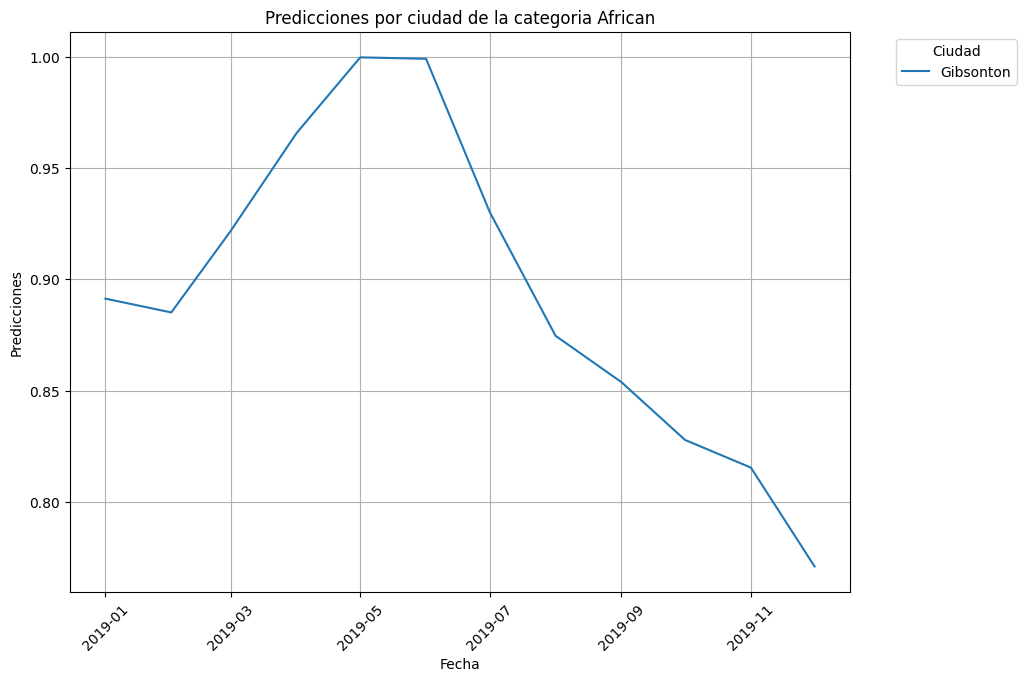

In [35]:
plt.figure(figsize=(12, 8))
for ciudad in ciudades_filtradas['city'].unique():
    ciudad_df = ciudades_filtradas[ciudades_filtradas['city'] == ciudad]
    plt.plot(ciudad_df['fecha'], ciudad_df['predicciones'], label=ciudad)
plt.xlabel('Fecha')
plt.ylabel('Predicciones')
plt.title(f'Predicciones por ciudad de la categoria {categoria_string}')
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.2)
plt.show()

In [ ]:
predicciones = []
fechas = []
categorias_unicas = []
for categoria_1 in df_categorias['category']:
    for categoria_2 in df_categorias['category']:
        if categoria_1!=categoria_2:
            ciudad='Truckee'
            categorias=[categoria_1,categoria_2]
            ciudad_numero=ciudad_numero_funcion(ciudad,df_ciudad)
            lat,lon=lat_lon(ciudad_numero,df_full_2)
            categoria_numeros=categorias_funcion(categorias,df_categorias)
            for anio in [2019]:
                for mes in range(1, 13):
                    features = [ciudad_numero, lat, lon] + categoria_numeros + [anio, mes]
                    columns = ['city', 'latitude', 'longitude', 'category_1', 'category_2', 'category_3', 
                                'category_4', 'category_5', 'year', 'month']
                    features_df = pd.DataFrame([features], columns=columns)
                    prediccion = model.predict(features_df)[0]
                    predicciones.append(prediccion)
                    fechas.append(f"{anio}-{mes:02d}")
                    categorias_unicas.append(categorias)
        else:
            continue

In [ ]:
resultados_df = pd.DataFrame({'categorias': categorias_unicas, 'fecha': fechas, 'predicciones': predicciones})
resultados_df['fecha'] = pd.to_datetime(resultados_df['fecha'])
scaler = MinMaxScaler()
resultados_df['predicciones'] = scaler.fit_transform(resultados_df[['predicciones']])

In [ ]:
condicion_prediccion_2=resultados_df['predicciones'].mean()+0*resultados_df['predicciones'].std()
condicion_prediccion_2

In [ ]:
resultados_df['categorias'] = resultados_df['categorias'].apply(lambda x: ' - '.join(x) if isinstance(x, list) else x)
categorias_filtradas = resultados_df.groupby('categorias').filter(lambda x: x['predicciones'].mean() > condicion_prediccion_2)

In [ ]:
plt.figure(figsize=(12, 8))
for categoria in categorias_filtradas['categorias'].unique():
    categoria_df = categorias_filtradas[categorias_filtradas['categorias'] == categoria]
    plt.plot(categoria_df['fecha'], categoria_df['predicciones'], label=categoria)
plt.xlabel('Fecha')
plt.ylabel('Predicciones')
plt.title(f'Predicciones por categoria en la ciudad {ciudad}')
plt.legend(title='Categorias', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.2)
plt.show()

In [ ]:
df_categorias.head(10)